In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
from math import floor

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/wu/.local/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


In [2]:
# ticker and the start and end dates for testing
ticker =  '2800.HK'
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)
# download ticker 'Adj Close' price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head()

[*********************100%***********************]  1 of 1 completed


,2800.HK
Date,
2010-01-04,21.950001
2010-01-05,22.450001
2010-01-06,22.600000
2010-01-07,22.450001
2010-01-08,22.500000


In [3]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head()

,2800.HK,returns,direction
Date,,,
2010-01-05,22.450001,0.022523,1
2010-01-06,22.600000,0.006659,1
2010-01-07,22.450001,-0.006659,-1
2010-01-08,22.500000,0.002225,1
2010-01-11,22.600000,0.004435,1


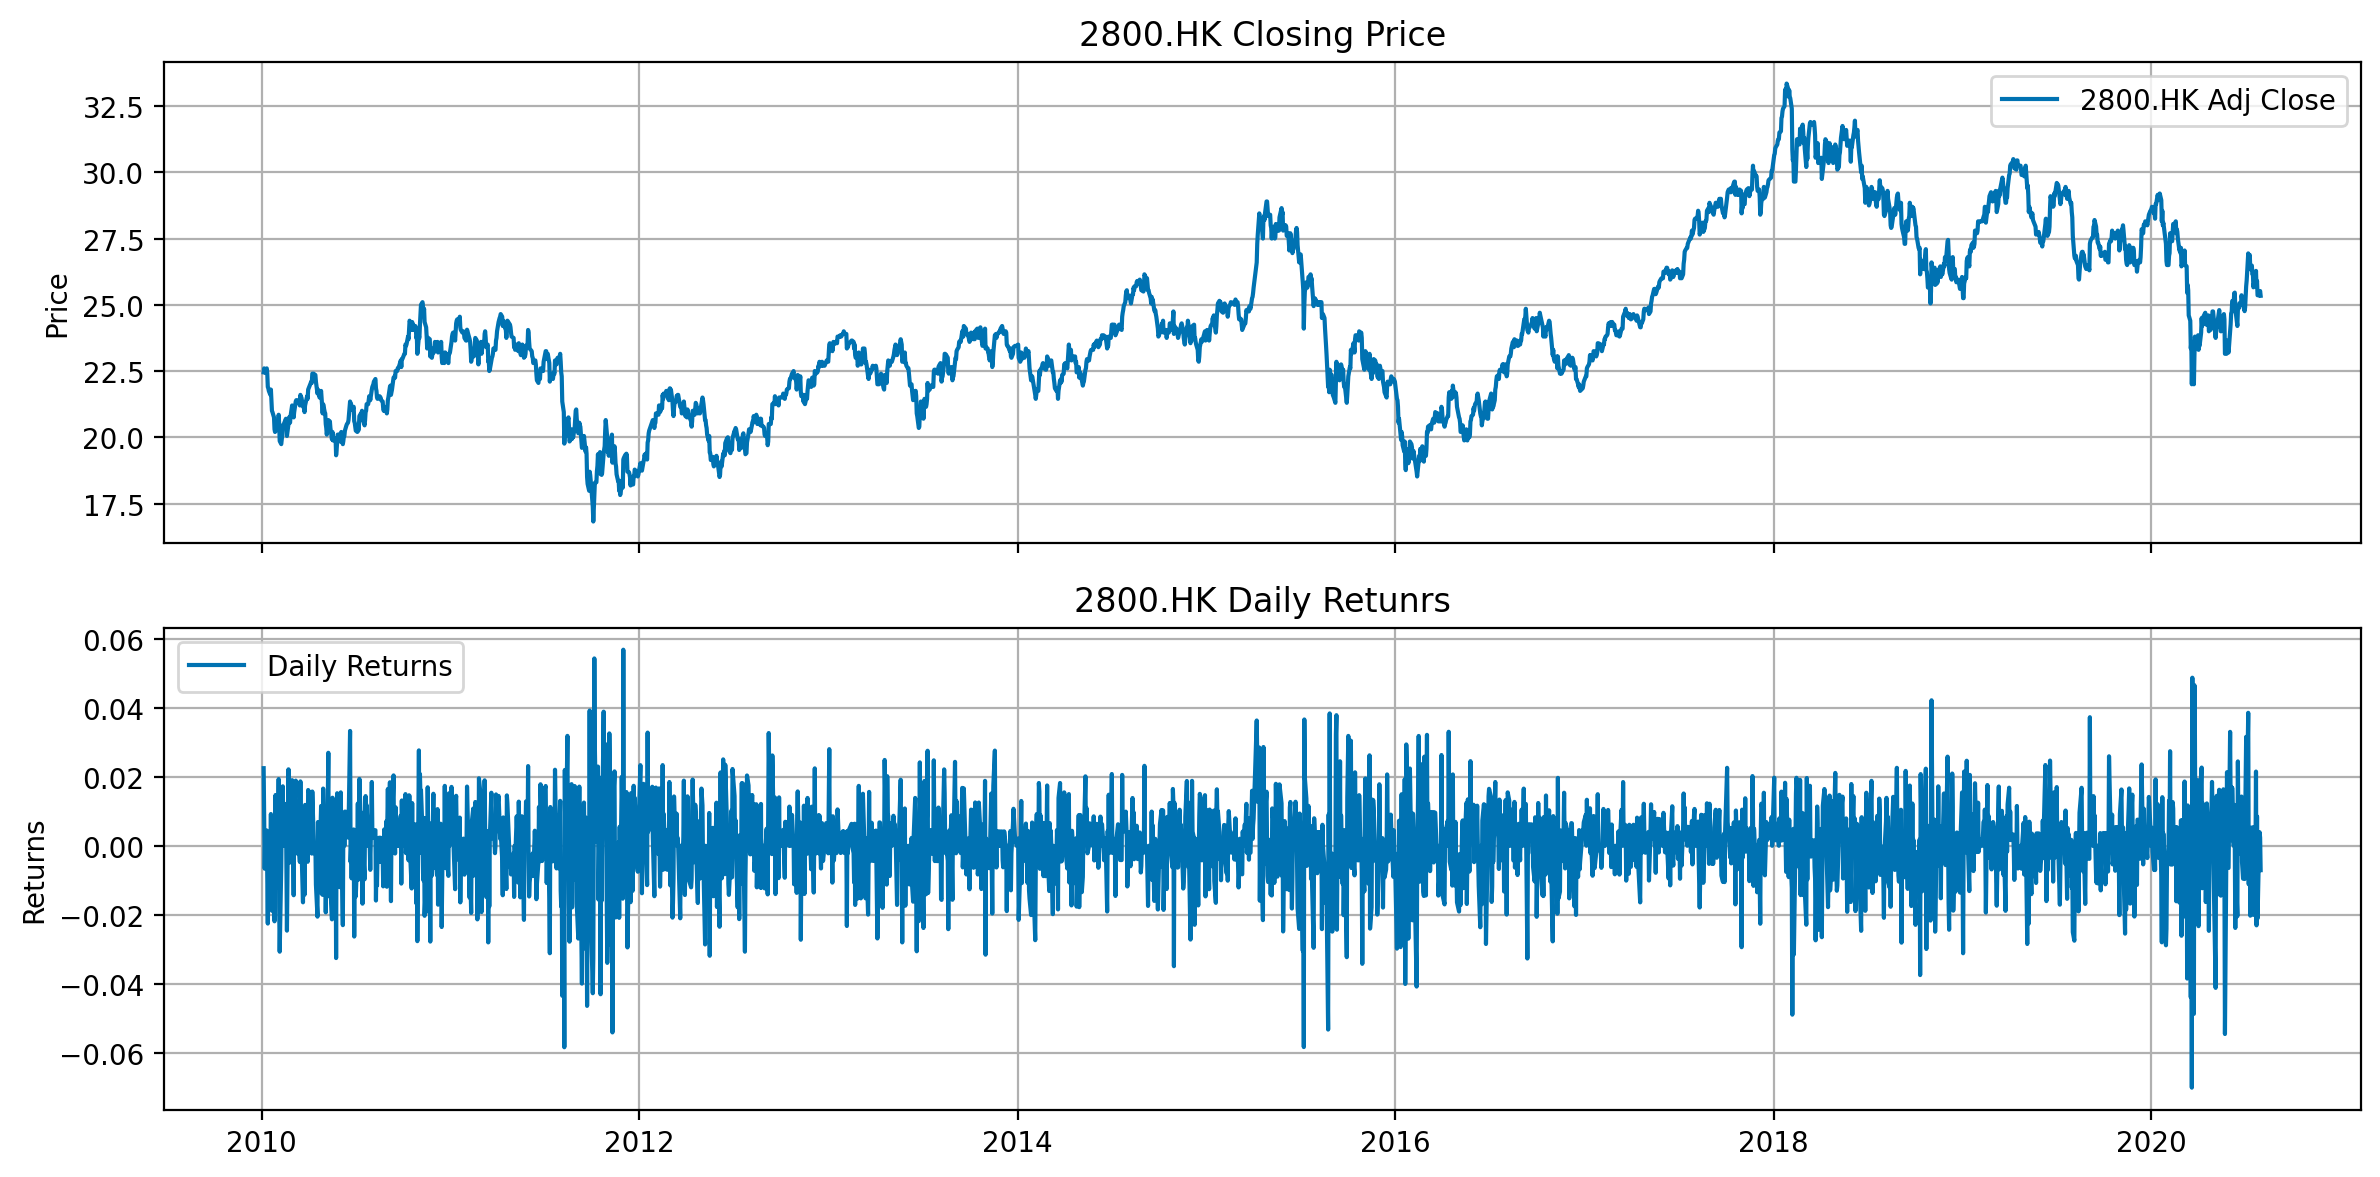

In [4]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()
ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()
plt.tight_layout()

In [5]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)
stock.dropna(inplace=True)
stock.head()

# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)
create_bins(stock)
stock[["returns"]+cols+cols_bin].head()

,returns,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,,
2010-01-12,-0.008889,0.004435,0.002225,-0.006659,0.006659,0.022523,1,1,0,1,1
2010-01-13,-0.022574,-0.008889,0.004435,0.002225,-0.006659,0.006659,0,1,1,0,1
2010-01-14,-0.002286,-0.022574,-0.008889,0.004435,0.002225,-0.006659,0,0,1,1,0
2010-01-15,-0.004587,-0.002286,-0.022574,-0.008889,0.004435,0.002225,0,0,0,1,1
2010-01-18,-0.006920,-0.004587,-0.002286,-0.022574,-0.008889,0.004435,0,0,0,0,1



Total Returns: 

returns                   1.121239
strategy_log_reg          1.635232
strategy_gauss_nb         1.635232
strategy_svm              3.673093
strategy_random_forest    6.912656
strategy_MLP              3.594989
dtype: float64

Annual Volitility:
returns                   0.191072
strategy_log_reg          0.191049
strategy_gauss_nb         0.191049
strategy_svm              0.190908
strategy_random_forest    0.190709
strategy_MLP              0.190913
dtype: float64
Number of trades SVM =  1072
Number of trades Ramdom Forest =  1422


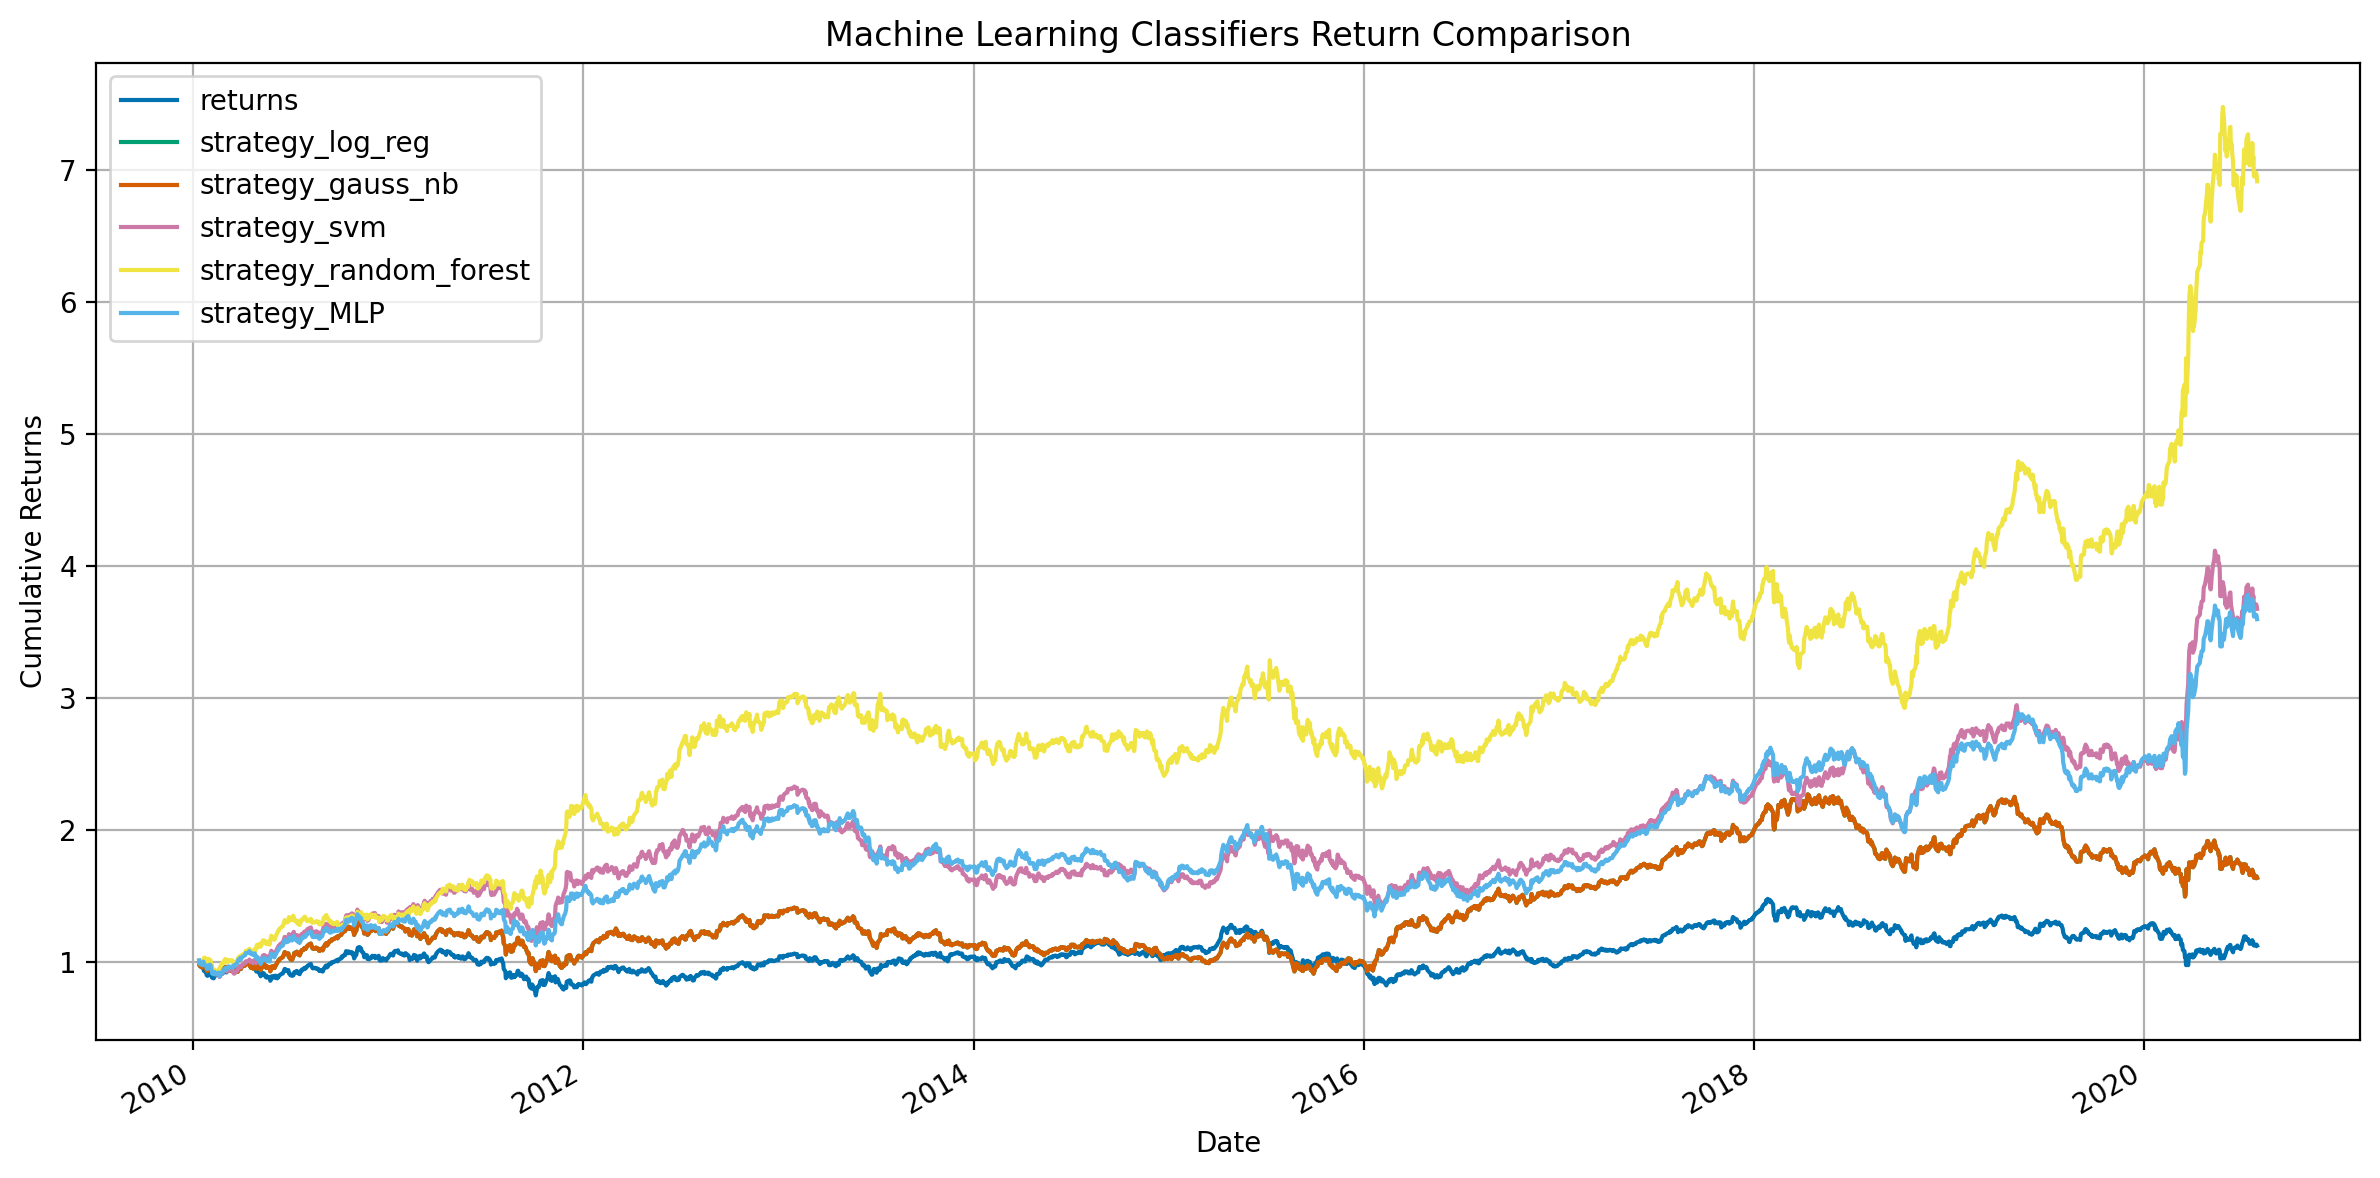

In [6]:
# create a dictionary of selected algorithms
models = {
 'log_reg': linear_model.LogisticRegression(),
 'gauss_nb': GaussianNB(),
 'svm': SVC(),
 'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
 'MLP' : MLPClassifier(max_iter=500),
}
# function that fits all models.
def fit_models(data):  
    mfit = {
        model: models[model].fit(
            data[cols_bin], 
            data['direction']) 
            for model in models.keys()
        }
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')
# fit the models
fit_models(stock)
# derives all position values
derive_positions(stock)
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)
# calculate total return and std. deviation of each strategy
print('\nTotal Returns: \n')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volitility:')
print(stock[strategy_rtn].std() * 252 ** 0.5)
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True)
plt.tight_layout()

In [7]:
# fetch the daily pricing data from yahoo finance
prices = yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-01-04,0.000000,22.200001,21.85,21.950001,21.950001,6239719,0,0
2010-01-05,22.200001,22.450001,22.10,22.450001,22.450001,7952312,0,0
2010-01-06,22.500000,22.700001,22.40,22.600000,22.600000,9995657,0,0
2010-01-07,22.700001,22.700001,22.35,22.450001,22.450001,5577754,0,0
2010-01-08,22.450001,22.600000,22.35,22.500000,22.500000,5276296,0,0


In [8]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
prices.head()

,open,high,low,close,volume
Date,,,,,
2010-01-04,0.000000,22.200001,21.85,21.950001,6239719
2010-01-05,22.200001,22.450001,22.10,22.450001,7952312
2010-01-06,22.500000,22.700001,22.40,22.600000,9995657
2010-01-07,22.700001,22.700001,22.35,22.450001,5577754
2010-01-08,22.450001,22.600000,22.35,22.500000,5276296


In [9]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='left').dropna()
prices.head()

,predicted,open,high,low,close,volume
Date,,,,,,
2010-01-12,0.008889,22.600000,22.650000,22.299999,22.40,5649424
2010-01-13,-0.022574,22.200001,22.200001,21.650000,21.90,10966750
2010-01-14,-0.002286,22.000000,22.150000,21.799999,21.85,4093347
2010-01-15,0.004587,21.900000,21.950001,21.700001,21.75,4150191
2010-01-18,-0.006920,21.600000,21.799999,21.450001,21.60,6957523


In [10]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
    # create lines
    lines = tuple(cols)
    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [39]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict()
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    # def notify_order(self, order):
    #     if order.status in [order.Submitted, order.Accepted]:
    #         # order already submitted/accepted - no action required
    #         return
    #     # report executed order
    #     if order.status in [order.Completed]:
    #         if order.isbuy():
    #             self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
    #             self.price = order.executed.price
    #             self.comm = order.executed.comm
    #         else:
    #             self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}')
    #     # report failed order
    #     elif order.status in [order.Canceled, order.Margin, order.Rejected]:
    #         self.log(f'Order Failed: {order.status}')
    #     # set no pending order
    #     self.order = None
    # def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if self.data_predicted > 0:
            # calculate the max number of shares ('all-in')
            size = int(self.broker.getcash() / self.datas[0].open * 1)
            # buy order
            # self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
            self.buy(size=size)
        if self.data_predicted < 0 and self.position:
            # sell order
            size = int(self.position.size * 1)
            # self.log(f'SELL CREATED --- Size: {size}')
            self.sell(size=size)
            

In [40]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
Final Portfolio Value: 3434179.07


In [13]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head()

index
2010-01-12 00:00:00+00:00    0.000000
2010-01-13 00:00:00+00:00    0.000000
2010-01-14 00:00:00+00:00    0.000000
2010-01-15 00:00:00+00:00   -0.006849
2010-01-18 00:00:00+00:00   -0.006896
Name: Strategy, dtype: float64

In [14]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = ticker
benchmark_rets.head()

Date
2010-01-12 00:00:00+00:00   -0.008889
2010-01-13 00:00:00+00:00   -0.022574
2010-01-14 00:00:00+00:00   -0.002286
2010-01-15 00:00:00+00:00   -0.004587
2010-01-18 00:00:00+00:00   -0.006920
Name: 2800.HK, dtype: float64

In [15]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2010-01-12
End date,2020-07-30
Total months,123
,Backtest
Annual return,40.8%
Cumulative returns,3334.2%
Annual volatility,13.5%
Sharpe ratio,2.61
Calmar ratio,3.48
Stability,0.99
Max drawdown,-11.7%


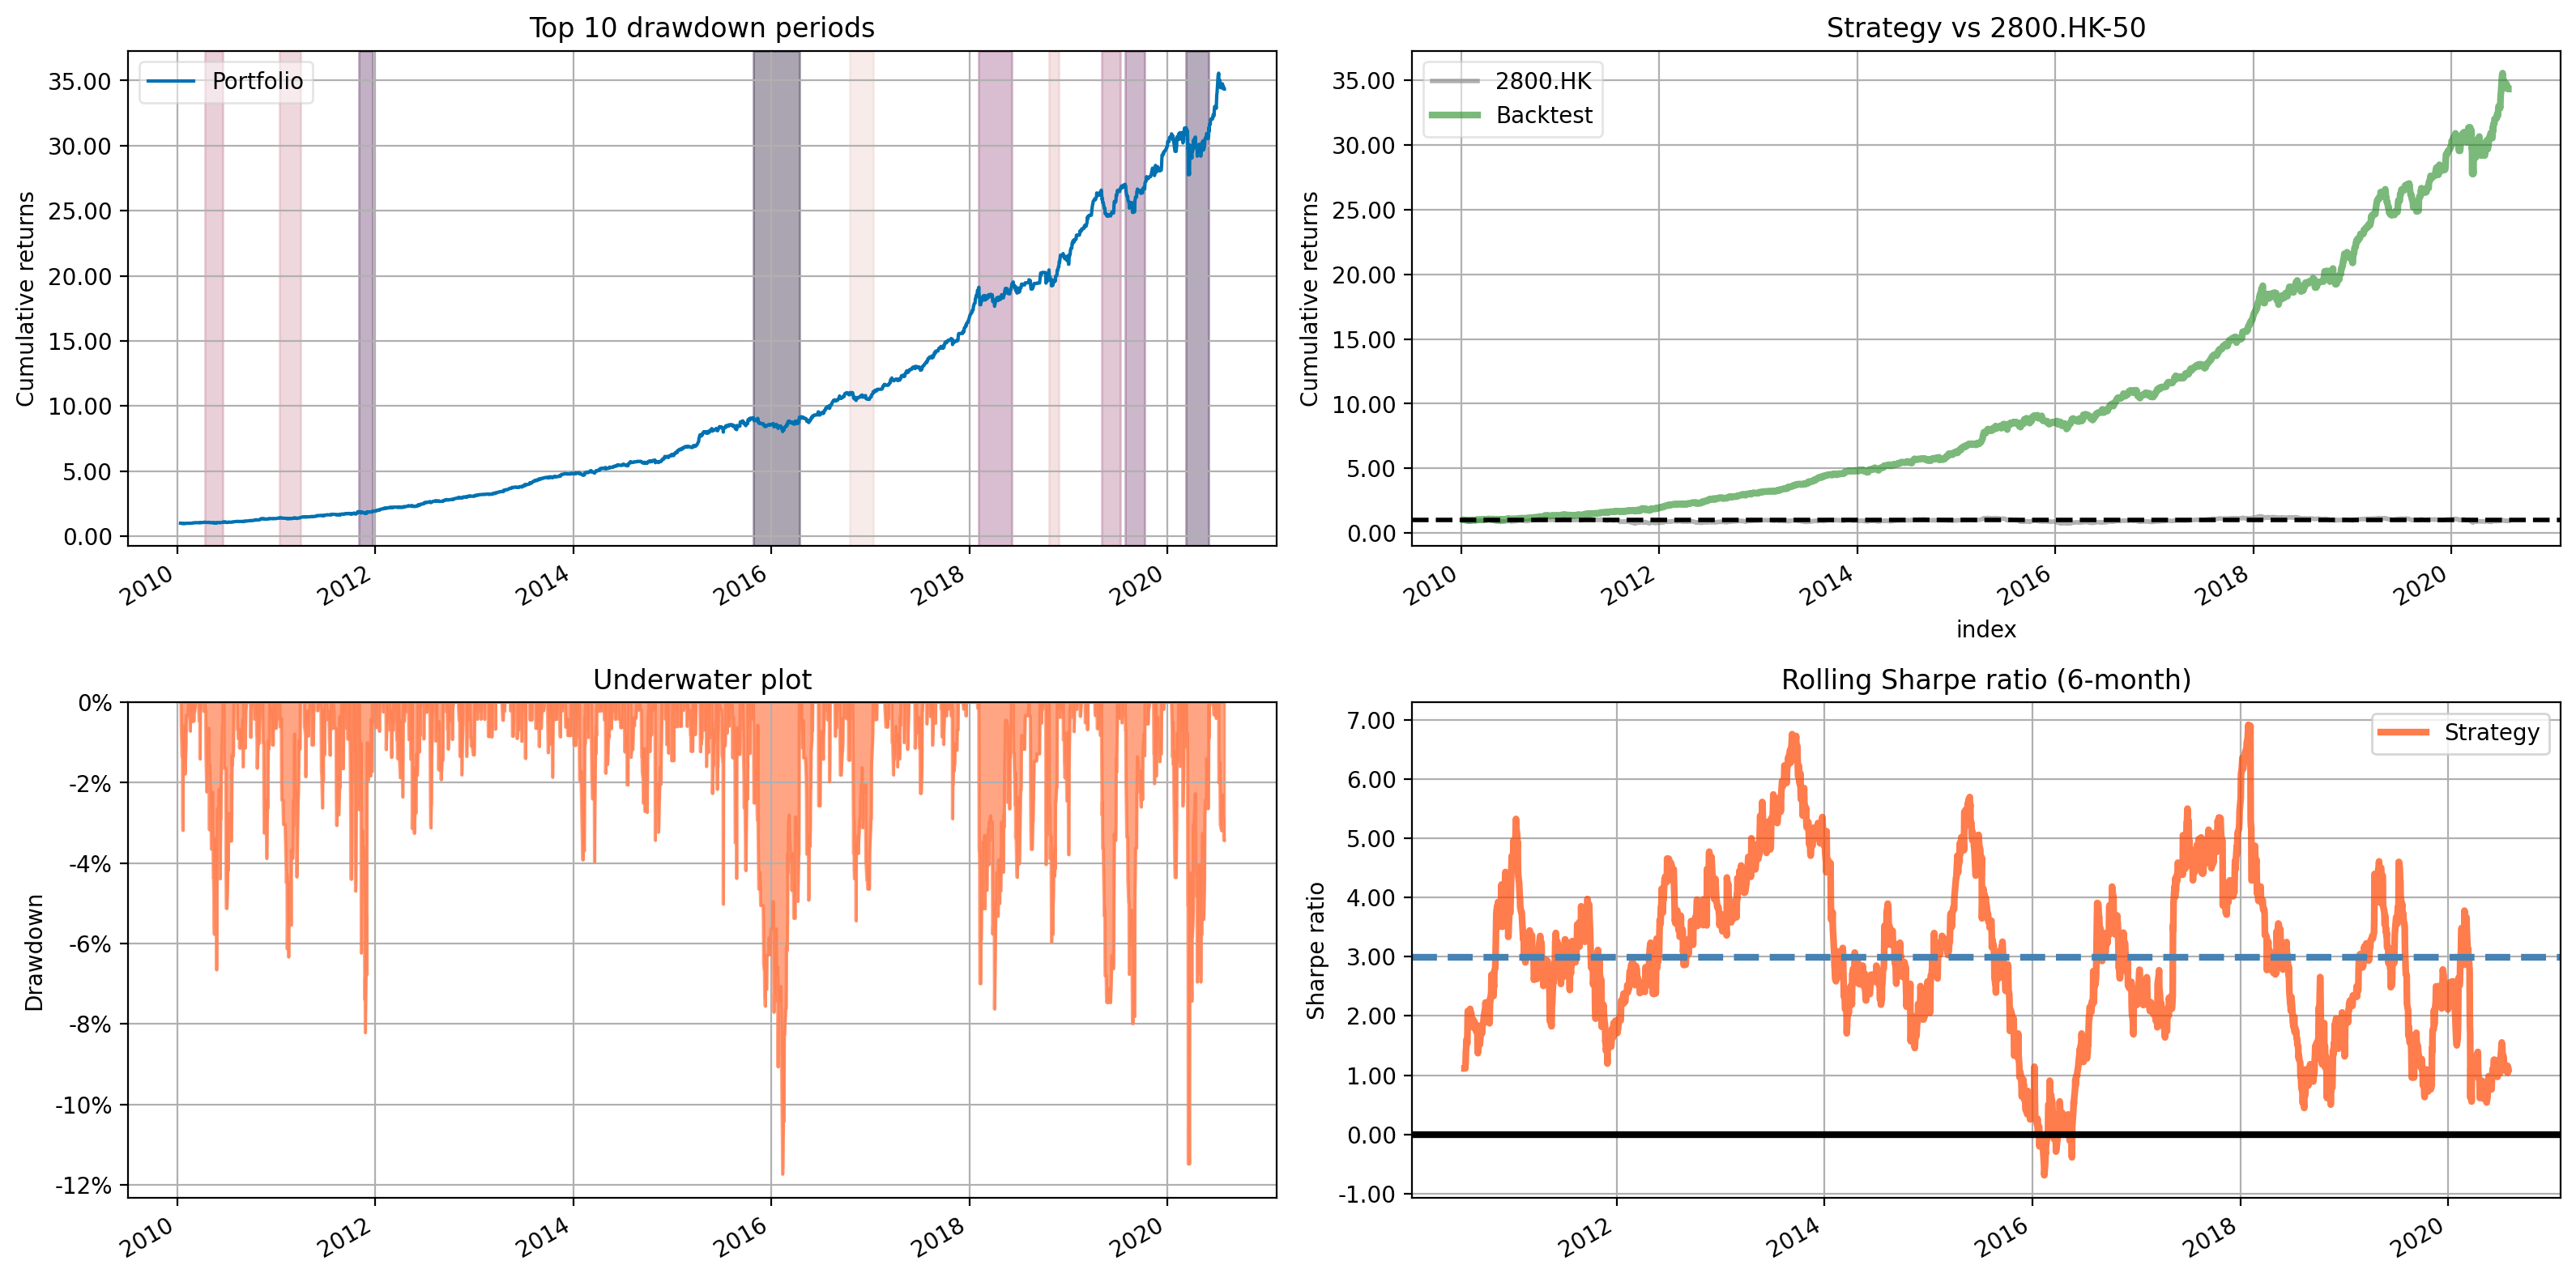

In [16]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8),constrained_layout=True)
axes = ax.flatten()
pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title=f'Strategy vs {ticker}-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)

plt.grid(True)
plt.legend()
plt.tight_layout()